In [1]:
import numpy as np
import pylab as plt
%matplotlib notebook
npix = 128
width = 120
stimlen = 192
refreshRate = 60.
bandwidth = 0.5 # in octave, +- from the center frequency
sf_c = 0.5
sf_0 = 0.02
tf_0 = 2.
beta = -1
contrast = 0.3
sigmarange = 3 # sigmarange = 3 to cover 99% confidence interval
import time
tstart = time.time()

def freqspace(n = 128):
    ''' 
    Mimic matlab freqspace with meshgrid option and for 2 dims.
    returns X,Y in the same order as matlab.
    '''
    f1 = (np.arange(0,n)-np.floor(n/2)) * (2/n)
    return np.meshgrid(f1,f1)
    
# Spatial frequency grig
Fxy = npix/width; # samples / deg
ux,uy = freqspace(npix)
vxy = Fxy/2.*np.sqrt(ux**2.+uy**2.)

# Temporal frequency grid
ut = (np.arange(0,stimlen)-np.floor(stimlen/2)) * (2/stimlen)
vt = refreshRate/2.*ut;

# Amplitude spectrum, space
Hxy = ((vxy+sf_c)**beta)*np.abs(vxy<=sf_0)
Hxy = np.transpose(Hxy[...,None] + np.zeros(stimlen)[None,None,:],[2,0,1])

# Amplitude spectrum, time
if tf_0 > 0:
    Ht = np.abs(vt) <= tf_0
    Ht = np.transpose(Ht[None,None,:]+np.zeros_like(Hxy[0])[...,None],[2,0,1])

# space-time
H =Hxy*Ht;
x = np.random.randn(stimlen,npix,npix)

X = np.fft.fftshift(np.fft.fftn(x));     
Y = X*H;
y = np.real(np.fft.ifftn(np.fft.fftshift(Y)));

sigma = np.std(y);
lims = sigmarange*np.array([-1.*sigma,sigma]); 
r = (((y*contrast)-lims[0])/(lims[1]-lims[0])*255).astype(np.uint8)

%matplotlib notebook
nbPlayStack(r,clim=[0,255],cmap = 'gray',interpolation='none')
plt.colorbar()
np.min(r),np.max(r)

Hxy.shape
print((time.time() - tstart)/60.)

NameError: name 'nbPlayStack' is not defined

<IPython.core.display.Javascript object>


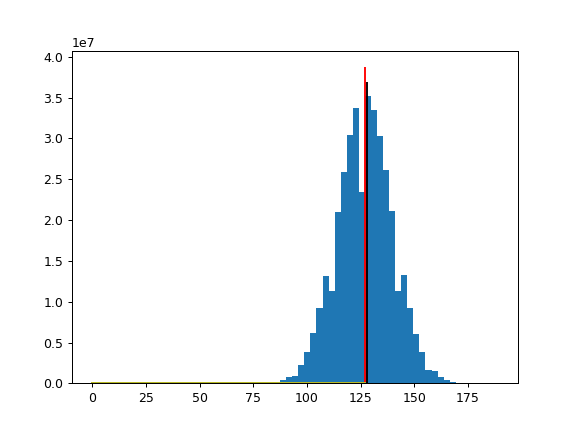

126.99291077984704

In [101]:
%matplotlib notebook
plt.hist(r.flatten(),50)
plt.vlines(128,0,np.max(plt.ylim()))
plt.vlines(np.mean(r),0,np.max(plt.ylim()),color='r')
np.mean(r)

<IPython.core.display.Javascript object>


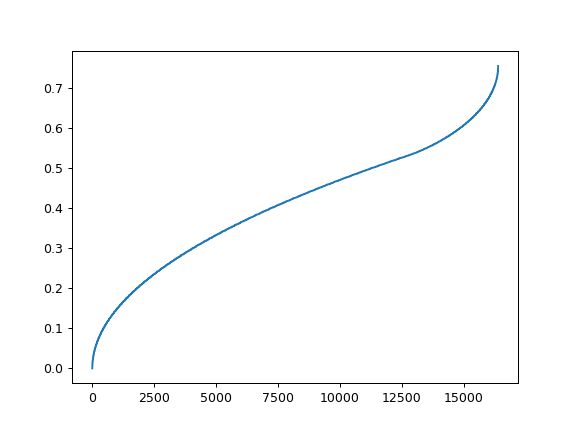

In [104]:
%matplotlib notebook
plt.plot(np.sort(vxy.flatten()))

In [7]:
from ipywidgets import (interact, interactive, fixed, interact_manual)
from ipywidgets import (Select, Textarea, Button,Dropdown, VBox,
                        HBox, Layout, Label, Text,Play,jslink)
from IPython.display import display

from pymysql.err import IntegrityError


from os.path import join as pjoin

import pylab as plt
from ipywidgets import *
from IPython.display import display
import time

from ipywidgets import Play,jslink,HBox
def nbPlayStack(data,interval=30,**kwargs):
    im = plt.imshow(data[0],**kwargs)
    slider = widgets.IntSlider(0,min = 0,max = len(data)-1,step = 1,description='Frame')
    play = widgets.Play(interval=interval,
                        value=0,
                        min=0,
                        max=len(data)-1,
                        step=1,
                        description="Press play",
                        disabled=False)
    jslink((play, 'value'), (slider, 'value'))
    display(HBox([play, slider]))
    
    def updateImage(change):
        im.set_data(data[change['new']])
    slider.observe(updateImage, names='value')
    return dict(fig = plt.gcf(),ax=plt.gca(),im= im)


<IPython.core.display.Javascript object>


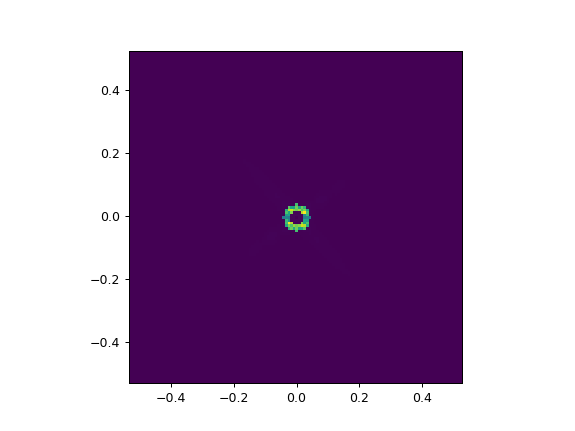

<IPython.core.display.Javascript object>


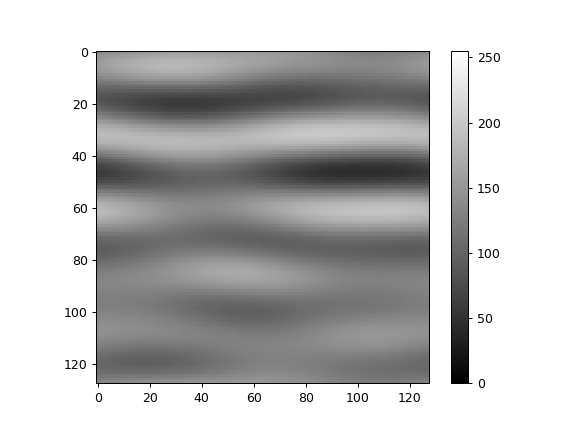

HBox(children=(Play(value=0, description='Press play', interval=30, max=591), IntSlider(value=0, description='Frame', max=591)))

<IPython.core.display.Javascript object>


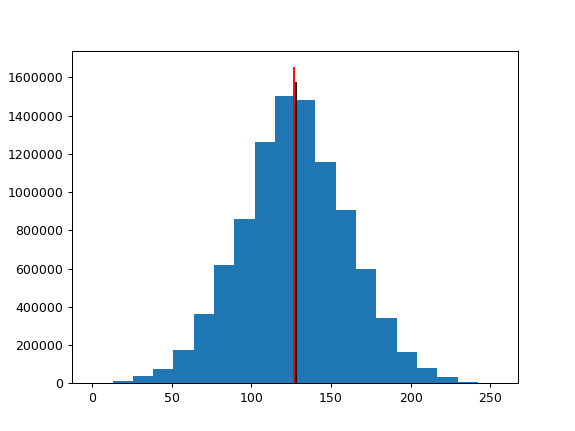

10.280001401901245


In [14]:
import numpy as np
import pylab as plt


from scipy import fftpack as fft
#from numpy import fft
%matplotlib notebook
npix = 128

ndec = 1
npix_dec = npix*ndec # to avoid correlations in space because of the fft
width = 120
width_dec = width*ndec
stimlen = 592
refreshRate = 60.
bandwidth = 0.5 # in octave, +- from the center frequency
# anisotropy = 0 # degree of anisotropy, 0 is isotropic, 90 is very oriented
seed = 123

sf_c = 0.5
sf_0 = 0.03
tf_0 = 3.
contrast = 0.8
sigmarange = 3 # sigmarange = 3 to cover 99% confidence interval

anisotropy = 45

import time
tstart = time.time()

def freqspace(n = 128):
    ''' 
    Mimic matlab freqspace with meshgrid option and for 2 dims.
    returns X,Y in the same order as matlab.
    '''
    f1 = (np.arange(0,n)-np.floor(n/2)) * (2/n)
    return np.meshgrid(f1,f1)
    
# Spatial frequency grig
Fxy = npix_dec/width_dec; # samples / deg
ux,uy = freqspace(int(npix_dec))
vxy = Fxy/2.*np.sqrt(ux**2.+uy**2.)

# Temporal frequency grid
ut = (np.arange(0,stimlen)-np.floor(stimlen/2)) * (2/stimlen)
vt = refreshRate/2.*ut;

# Amplitude spectrum, 
# go to normalized logscale space for the bandpass
minsf = np.sort(vxy.flatten())[1];
with np.errstate(divide='ignore'):
    vxy_norm=np.log2(vxy/minsf)
lowlim=np.log2(sf_0/minsf)-bandwidth;
uplim=np.log2(sf_0/minsf)+bandwidth;

Hxy = (1./(vxy+sf_c))*np.abs((vxy_norm<=uplim) * (vxy_norm>=lowlim))

Hxy = np.transpose(Hxy[...,None] + np.zeros(stimlen)[None,None,:],[2,0,1])

# Amplitude spectrum, time
if tf_0 > 0:
    Ht = np.abs(vt) <= tf_0
    Ht = np.transpose(Ht[None,None,:]+np.zeros_like(Hxy[0])[...,None],[2,0,1])

# space-time
H =Hxy*Ht;
np.random.seed(seed=seed)
x = np.random.rand(stimlen,npix_dec,npix_dec)

X = fft.fftshift(fft.fftn(x));     
Y = X*H;
y = np.real(fft.ifftn(fft.fftshift(Y)));

if anisotropy > 0:
    ori_grad = np.linspace(0,180,stimlen);
    f1 = np.arange(npix_dec) - np.floor(npix_dec/2)
    [xx,yy]= np.meshgrid(f1,f1)
    zz = xx+1j*yy
    for ilen in range(stimlen):
        org_img= y[ilen]
        x1 = fft.fftshift(fft.fftn(org_img));
        phase = np.angle(x1);
        mag = np.abs(x1);
        vonmises = ((np.exp(-1*anisotropy*np.cos(np.angle(zz) + ori_grad[ilen]/180*np.pi))) +
                    np.rot90(np.rot90(np.exp(-1*anisotropy*np.cos(np.angle(zz) + ori_grad[ilen]/180*np.pi)))))
#         %     magNew= (1./(vxy+pars.sf_c)).*abs(vxy<=pars.sf_new(ilen));
        VonMises =vonmises/np.max(vonmises);
        magNew = mag*(vonmises);
        y1= magNew*np.exp(1j*phase);
        y2 = np.real(fft.ifftn(fft.fftshift(y1)));
        y[ilen,:,:] = y2;
#     end
# end

sigma = np.std(y.flatten());
lims = sigmarange*np.array([-1.*sigma,sigma]); 
r = (((y*contrast)-lims[0])/(lims[1]-lims[0])*255).astype(np.uint8)
#r = r[:,int(npix/2):int(npix/2+npix),int(npix/2):int(npix/2+npix)];
r = r[:,0:int(npix),0:int(npix)];
%matplotlib notebook



tmp = fft.fftshift(np.abs(fft.fft2(r.astype(float))))
freqs =  Fxy/2.*(np.arange(0,npix)-np.floor(npix/2)) * (2/npix)
tmp[:,int(npix/2),int(npix/2)] = 0
plt.imshow(np.mean(tmp[:],axis=0),extent=[freqs[0],freqs[-1],freqs[0],freqs[-1]])

plt.figure()
nbPlayStack(r,clim=[0,255],cmap = 'gray',interpolation='none')
plt.colorbar()
np.min(r),np.max(r)
plt.figure()
plt.hist(r.flatten(),20)
plt.vlines(128,0,np.max(plt.ylim()))
plt.vlines(np.mean(r),0,np.max(plt.ylim()),color='r')
np.mean(r)

Hxy.shape
print((time.time() - tstart))

<IPython.core.display.Javascript object>


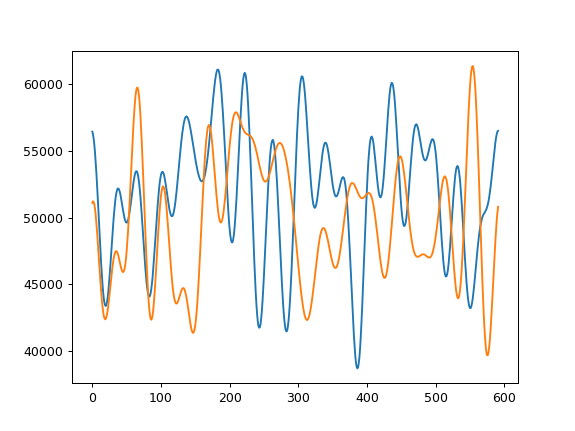

<IPython.core.display.Javascript object>


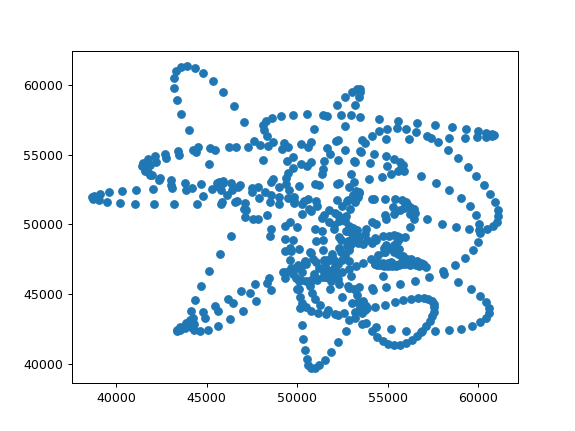

<IPython.core.display.Javascript object>


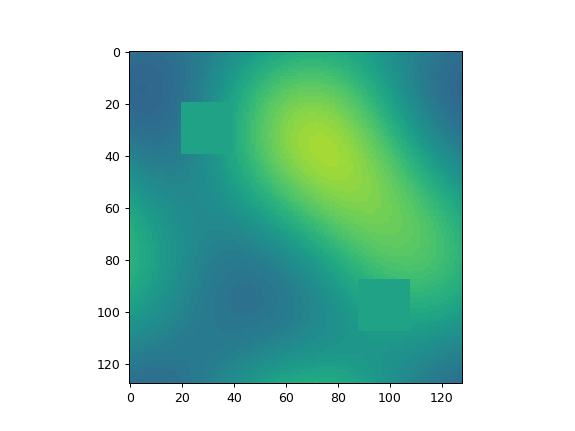

HBox(children=(Play(value=0, description='Press play', interval=30, max=591), IntSlider(value=0, description='Frame', max=591)))

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f60159b9d68>,
 'fig': <Figure size 640x480 with 1 Axes>,
 'im': <matplotlib.image.AxesImage at 0x7f601488b0b8>}

In [249]:
%matplotlib notebook
s1 = np.sum(np.sum(r[:,20:40,20:40],axis = 1),axis=1)
s2 = np.sum(np.sum(r[:,-40:-20,-40:-20],axis = 1),axis=1)
plt.plot(s1)
plt.plot(s2)
plt.figure()
plt.scatter(s1,
            s2)
plt.figure()
nr = r.copy()
nr[:,20:40,20:40] = 128
nr[:,-40:-20,-40:-20] = 128
nbPlayStack(nr)

'f95a3bc'

'f95a3bc'